<a href="https://colab.research.google.com/github/altaga/Open-Driving-Monitor/blob/main/Yolo/test/LoadAndTestYolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download models and image for the test

In [1]:
# Tiny
!wget https://pjreddie.com/media/files/yolov3-tiny.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg
# Labels
!wget https://opencv-tutorial.readthedocs.io/en/latest/_downloads/a9fb13cbea0745f3d11da9017d1b8467/coco.names
# Test Image
!wget https://raw.githubusercontent.com/altaga/Open-Driving-Monitor/main/Yolo/test/yoloTest.jpg

--2023-11-28 05:54:08--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  17.0MB/s    in 2.0s    

2023-11-28 05:54:10 (17.0 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]

--2023-11-28 05:54:11--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915 (1.9K) [text/plain]
Saving to: ‘yolov3-tiny.cfg’

yolov3-tiny.cfg     100%[===================>]   1.87K  --.

Testing image and display the results. Since YoloV3 networks are already trained by the Darknet team, we are only implementing them in OpenCV DNN.

car: 0.7167
car: 0.7647
car: 0.7670
car: 0.8448
person: 0.7508
person: 0.7725
person: 0.9286
person: 0.6161
0.8227445550000001


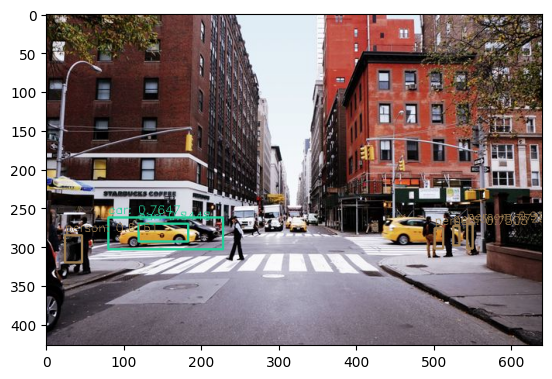

In [2]:
# YOLO object detection
import cv2 as cv
import numpy as np
import time
from matplotlib import pyplot as plt
import time

minConfidence  = 0.5

confidences = []
boxes = []
classIDs = []
classes = open('coco.names').read().strip().split('\n')

img = cv.imread('yoloTest.jpg')
colorIMG = cv.cvtColor(img, cv.COLOR_BGR2RGB)
net = cv.dnn.readNetFromDarknet('yolov3-tiny.cfg', 'yolov3-tiny.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
start = time.process_time()
blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]
net.setInput(blob)
outputs = net.forward(ln)

# Usable Detections as data
for output in outputs:
  for detection in output:
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
    if confidence >= minConfidence:
      confidences.append(float(confidence))
      classIDs.append(classID)

if len(confidences) > 0:
  for i in range(0,len(confidences)):
    text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
    print(text)

print(time.process_time() - start)

# Show Detections

boxes = []
confidences = []
classIDs = []
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')
h, w = img.shape[:2]

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence >= minConfidence:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(colorIMG, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv.putText(colorIMG, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

plt.imshow(colorIMG)
